In [1]:
import pandas as pd
import os
import yaml
import torch
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
matplotlib.pyplot.rcParams['figure.figsize'] = (15, 6)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'

In [6]:
def compute_sparsity(model_fn, threshold=10e-3):
    is_zero = 0
    non_zero = 0
    for name, tensor in torch.load(model_fn).items():
        m = tensor.cpu().numpy()
        close = len(np.where(np.abs(m) <= threshold)[0])
        is_zero += close
        non_zero += (m.size - close)
    return is_zero, non_zero, is_zero / (is_zero + non_zero)
    
    
def get_min_loss(row):
    min_idx, min_dev_loss = min(enumerate(row['dev_loss']), key=lambda x: x[1])
    min_train_loss = row['train_loss'][min_idx]
    row['min_dev_loss'] = min_dev_loss
    row['min_train_loss'] = min_train_loss
    return row
    
    
def extract_language_name(field):
    fn = field.split('/')[-1]
    if 'dev' in fn:
        return '-'.join(fn.split('-')[:-1])
    return '-'.join(fn.split('-')[:-2])
    

def load_res_dir(basedir, include_sparsity=False):
    experiments = []
    for subdir in os.scandir(basedir):
        exp_d = {}
        with open(os.path.join(subdir.path, "config.yaml")) as f:
            exp_d.update(yaml.load(f))
        res_fn = os.path.join(subdir.path, "result.yaml")
        if os.path.exists(res_fn):
            with open(os.path.join(subdir.path, "result.yaml")) as f:
                exp_d.update(yaml.load(f))
        else:
            continue
        dev_acc_path = os.path.join(subdir.path, "dev.word_accuracy")
        if os.path.exists(dev_acc_path):
            with open(dev_acc_path) as f:
                exp_d['dev_acc'] = float(f.read())
        else:
            print("Dev accuracy file does not exist in dir: {}".format(subdir.path))
        if include_sparsity:
            exp_d['sparsity'] = compute_sparsity(os.path.join(subdir.path, "model"), 10e-4)
        experiments.append(exp_d)
    experiments = pd.DataFrame(experiments)
    if include_sparsity:
        experiments['sparsity_ratio'] = experiments['sparsity'].apply(lambda x: x[2])
    experiments['language'] = experiments.dev_file.apply(extract_language_name)
    experiments = experiments.apply(get_min_loss, axis=1)
    experiments = experiments[experiments['dev_acc'].notnull()]
    experiments = experiments[experiments['dev_loss'].notnull()]
    experiments['train_size'] = experiments['train_file'].apply(lambda fn: fn.split('-')[-1])
    return experiments

# Luong attention seq2seq

In [7]:
luong = load_res_dir("../exps/sigmorphon_2018/luong_hyperparam_search/")
luong.head()

,batch_size,cell_type,dataset_class,defaults,dev_acc,dev_file,dev_loss,dropout,early_stopping_ratio,embedding_size_src,...,train_file,train_loss,use_eos,use_step,vocab_path_src,vocab_path_tgt,language,min_dev_loss,min_train_loss,train_size
0,128,LSTM,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.817,/mnt/permanent/home/judit/projects/deep-morpho...,"[0.023873119592666626, 0.020675533771514893, 0...",0.2,1.5,10,...,/mnt/permanent/home/judit/projects/deep-morpho...,"[0.02462552695274353, 0.022512354850769044, 0....",True,False,/mnt/permanent/home/judit/projects/deep-morpho...,/mnt/permanent/home/judit/projects/deep-morpho...,hungarian,0.000538,0.000413,high
1,128,LSTM,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.821,/mnt/permanent/home/judit/projects/deep-morpho...,"[0.023945430755615234, 0.021567680835723878, 0...",0.2,1.5,10,...,/mnt/permanent/home/judit/projects/deep-morpho...,"[0.024921917390823365, 0.02244206266403198, 0....",True,False,/mnt/permanent/home/judit/projects/deep-morpho...,/mnt/permanent/home/judit/projects/deep-morpho...,hungarian,0.000497,0.000361,high
2,128,LSTM,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.191,/mnt/permanent/home/judit/projects/deep-morpho...,"[0.023964147329330443, 0.023558178424835204, 0...",0.4,1.5,10,...,/mnt/permanent/home/judit/projects/deep-morpho...,"[0.02505976309776306, 0.02335397810935974, 0.0...",True,False,/mnt/permanent/home/judit/projects/deep-morpho...,/mnt/permanent/home/judit/projects/deep-morpho...,hungarian,0.003113,0.004525,high
3,128,LSTM,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.834,/mnt/permanent/home/judit/projects/deep-morpho...,"[0.02451201057434082, 0.023875764608383178, 0....",0.2,1.5,20,...,/mnt/permanent/home/judit/projects/deep-morpho...,"[0.02666620283126831, 0.023718895411491393, 0....",True,False,/mnt/permanent/home/judit/projects/deep-morpho...,/mnt/permanent/home/judit/projects/deep-morpho...,hungarian,0.000497,0.000362,high
4,128,LSTM,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.510,/mnt/permanent/home/judit/projects/deep-morpho...,"[0.024245388746261597, 0.023477741956710815, 0...",0.5,1.5,30,...,/mnt/permanent/home/judit/projects/deep-morpho...,"[0.02538008646965027, 0.02345137984752655, 0.0...",True,False,/mnt/permanent/home/judit/projects/deep-morpho...,/mnt/permanent/home/judit/projects/deep-morpho...,hungarian,0.001829,0.001454,high


In [8]:
params = ['embedding_size_src', 'embedding_size_tgt', 'hidden_size', 'dropout', 'num_layers_src', 'num_layers_tgt']

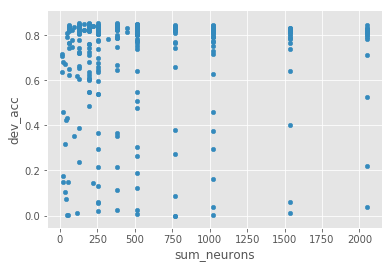

In [11]:
luong['sum_neurons'] = (luong['num_layers_src'] + luong['num_layers_tgt']) * luong['hidden_size']
luong[luong.language=='hungarian'].plot(kind='scatter', x='sum_neurons', y='dev_acc')

In [16]:
hun = luong[luong.language=='hungarian']
best_n = hun['dev_acc'].sort_values(ascending=False)[:10]
hun.loc[best_n.index][['dev_acc'] + params]

,dev_acc,embedding_size_src,embedding_size_tgt,hidden_size,dropout,num_layers_src,num_layers_tgt
174,0.856,30,30,64,0.4,1,1
107,0.854,30,20,64,0.3,2,1
191,0.852,30,30,128,0.5,2,1
241,0.852,20,30,128,0.2,1,1
85,0.851,30,20,128,0.5,3,1
325,0.851,50,50,64,0.3,2,1
276,0.849,50,50,32,0.3,4,1
122,0.849,30,20,64,0.3,2,1
87,0.849,30,30,256,0.4,1,1
199,0.849,10,10,128,0.4,2,1


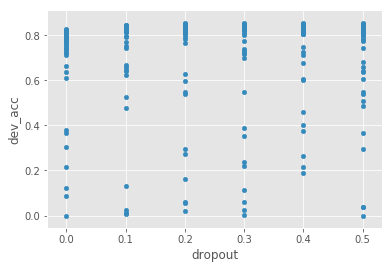

In [12]:
luong.plot(kind='scatter', x='dropout', y='dev_acc')

In [27]:
best_n = luong['dev_acc'].sort_values(ascending=False)[:10]
luong.loc[best_n.index][['dev_acc'] + params]

,dev_acc,embedding_size_src,embedding_size_tgt,hidden_size,dropout,num_layers_src,num_layers_tgt
174,0.856,30,30,64,0.4,1,1
107,0.854,30,20,64,0.3,2,1
241,0.852,20,30,128,0.2,1,1
191,0.852,30,30,128,0.5,2,1
85,0.851,30,20,128,0.5,3,1
122,0.849,30,20,64,0.3,2,1
199,0.849,10,10,128,0.4,2,1
87,0.849,30,30,256,0.4,1,1
72,0.849,20,10,64,0.2,2,1
200,0.848,30,30,64,0.2,2,1


In [14]:
luong.loc[luong.dev_acc.idxmax()][params]

embedding_size_src     30
embedding_size_tgt     30
hidden_size            64
dropout               0.4
num_layers_src          1
num_layers_tgt          1
Name: 174, dtype: object

In [94]:
%%time
experiments = load_res_dir("../exps/reinflection_ron")
exps2 = load_res_dir("../exps/reinflection")

experiments = pd.concat([experiments, exps2], axis=0)

CPU times: user 21.5 s, sys: 152 ms, total: 21.7 s
Wall time: 25.5 s


# Language distribution

In [95]:
experiments.language.value_counts()

hungarian             417
finnish                15
basque                 13
welsh                   9
faroese                 7
middle-high-german      6
sanskrit                5
friulian                5
livonian                5
maltese                 5
kabardian               5
spanish                 5
hebrew                  5
azeri                   5
sorani                  5
romanian                5
neapolitan              5
quechua                 5
norwegian-bokmaal       5
pashto                  5
adyghe                  5
navajo                  5
irish                   5
lower-sorbian           5
latvian                 5
kurmanji                5
old-saxon               5
hindi                   5
georgian                5
khaling                 5
                     ... 
votic                   4
west-frisian            4
uzbek                   4
tatar                   4
yiddish                 4
czech                   2
kazakh                  2
greenlandic 

In [97]:
experiments['train_size'].value_counts()

high                641
low                  83
medium               82
/proc/self/fd/11      5
Name: train_size, dtype: int64

# Variation by experiment

In [98]:
lemma_params = [c for c in experiments.columns if c.startswith('lemma')]
tag_params = [c for c in experiments.columns if c.startswith('tag')]
inflected_params = [c for c in experiments.columns if c.startswith('inflected')]
other_params = ['dropout']
params = lemma_params + tag_params + inflected_params + other_params
params.append('language')
params.append('train_size')

uniform_exps = experiments[experiments['lemma_embedding_size'] == 20]
dupl_exps = uniform_exps.groupby(params).filter(lambda x: len(x) > 1)
dupl_exps.groupby(params)[['dev_acc', 'min_dev_loss']].std().reset_index()[['language', 'dev_acc', 'min_dev_loss']]

,language,dev_acc,min_dev_loss
0,adyghe,0.149563,5.270253e-04
1,albanian,0.022869,1.865744e-04
2,arabic,0.015948,9.175529e-05
3,armenian,0.214584,8.868655e-04
4,asturian,0.011504,7.760846e-05
5,azeri,0.210000,1.847064e-03
6,bashkir,0.005657,7.484287e-05
7,basque,0.005657,2.243091e-05
8,belarusian,0.004243,5.291598e-05
9,bengali,0.106066,6.501044e-04


# Ignore medium and low training data experiments

In [99]:
experiments = experiments[experiments['train_size'] == 'high']

# 100%

In [102]:
experiments[experiments['dev_acc'] == 1]['language'].value_counts()

pashto       3
occitan      3
kabardian    3
swahili      3
uzbek        2
friulian     1
Name: language, dtype: int64

# at least 90% but less than 100%

In [107]:
experiments[(experiments.dev_acc >= 0.9) & (experiments.dev_acc < 1)].groupby('language')['dev_acc'].max()

language
adyghe              0.920
asturian            0.951
azeri               0.900
bashkir             0.983
basque              0.987
catalan             0.962
classical-syriac    0.980
crimean-tatar       0.990
finnish             0.914
friulian            0.990
galician            0.987
georgian            0.946
hebrew              0.974
khaling             0.995
ladin               0.960
lower-sorbian       0.962
maltese             0.950
middle-french       0.979
northern-sami       0.963
old-saxon           0.903
portuguese          0.970
quechua             0.986
sanskrit            0.904
slovak              0.930
tatar               0.980
urdu                0.986
venetian            0.995
welsh               0.960
yiddish             0.970
zulu                0.988
Name: dev_acc, dtype: float64

# Below 50%

In [114]:
m = experiments.groupby('language')['dev_acc'].max()
m[m < 0.5]

language
haida    0.140
hindi    0.413
irish    0.233
Name: dev_acc, dtype: float64

## Highest dec accuracy per language

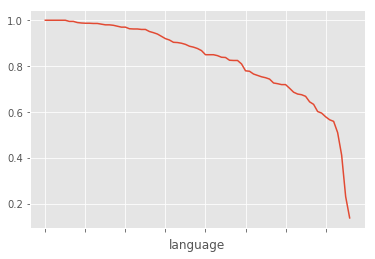

In [29]:
experiments.groupby('language').max()['dev_acc'].sort_values(ascending=False).plot()

# Hungarian experiments

In [39]:
hun = experiments[experiments.language=="hungarian"].copy()

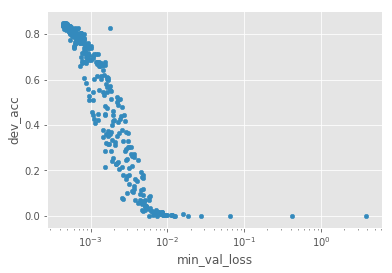

In [40]:
hun.plot(kind='scatter', x='min_val_loss', y='dev_acc', logx=True)

In [41]:
hun.loc[hun['dev_acc'].idxmax()]['experiment_dir']

'/mnt/permanent/home/judit/projects/deep-morphology/exps/reinflection/0078'

In [42]:
lemma_params = [c for c in hun.columns if c.startswith('lemma')]
tag_params = [c for c in hun.columns if c.startswith('tag')]
inflected_params = [c for c in hun.columns if c.startswith('inflected')]
other_params = ['dropout']
params = lemma_params + tag_params + inflected_params + other_params

hun.loc[hun['dev_acc'].idxmax()].loc[params]

lemma_embedding_size         20
lemma_hidden_size           128
lemma_num_layers              3
tag_embedding_size           10
tag_hidden_size              64
tag_num_layers                2
inflected_embedding_size     30
inflected_hidden_size       128
inflected_num_layers          2
dropout                     0.2
Name: 77, dtype: object

In [43]:
hun['lemma_neurons'] = hun['lemma_num_layers'] * hun['lemma_hidden_size']
hun['tag_neurons'] = hun['tag_num_layers'] * hun['tag_hidden_size']
hun['inflected_neurons'] = hun['inflected_num_layers'] * hun['inflected_hidden_size']
hun['sum_neurons'] = hun['lemma_neurons'] + hun['tag_neurons'] + hun['inflected_neurons']

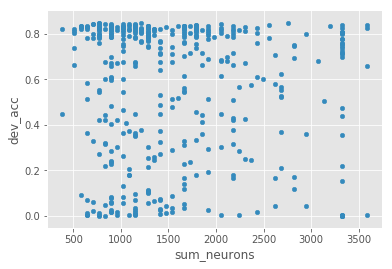

In [44]:
hun.plot(kind='scatter', x='sum_neurons', y='dev_acc')

In [45]:
hun.groupby('dropout').max()['dev_acc']

dropout
0.0    0.833
0.1    0.844
0.2    0.850
0.3    0.847
0.4    0.845
0.5    0.843
0.8    0.545
Name: dev_acc, dtype: float64

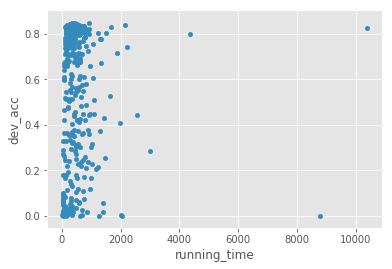

In [46]:
hun.plot(kind='scatter', x='running_time', y='dev_acc')

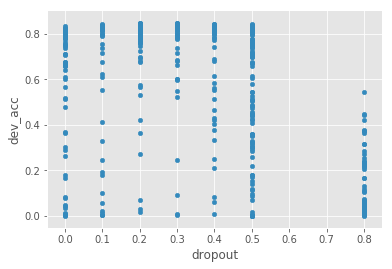

In [47]:
hun.plot(kind='scatter', x='dropout', y='dev_acc')

# Sparse models

L1 regularization

In [54]:
l1_reg_models = load_res_dir("../exps/sigmorphon_2018/l1_reg/", include_sparsity=True)

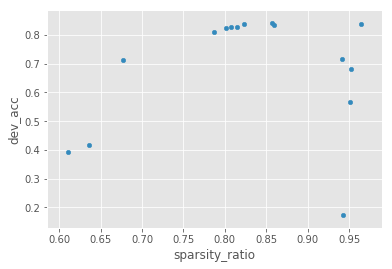

In [55]:
l1_reg_models.plot(kind='scatter', x='sparsity_ratio', y='dev_acc')